## Implement a global connector for number of protons vs. ionization enthalpy

Rules for new connectors:

+ It must be a subclass of pytc.global_models.GlobalConnector.
+ It must define param_guesses in the class namespace (i.e. at the top of the class definition.) This should have reasonable guesses for the parameters.
+ It must define required_data in the class namespace (i.e. at the top of the class definition.) These are strings that name the attributes of experiment that are required to do the calculation.
+ It must define output methods (like dH) that:
    + take only self and experiment as arguments.
    + use the parameters specified in param_guesses as attributes of self (e.g. self.dH_intrinsic above).
    + access any required information about the experiment from the experiment object.
+ There is no limit to the number of parameters, required data, or output methods.

Full docs:

https://pytc.readthedocs.io/en/latest/writing_new_models.html

In [1]:
%matplotlib inline
import pytc

/usr/local/lib/python3.5/dist-packages/pytc_fitter-0.1.0-py3.5.egg/pytc/indiv_models/single_site.py:32: RuntimeWarning: invalid value encountered in sqrt
  ST = (b - np.sqrt((b)**2 - 4*S_conc_corr*self._T_conc))/2


# Fit successful? True
# AIC: -87.39090294260919
# AICc: -84.1066924162934
# BIC: -57.887459444242765
# F: 295081.12408098724
# Rsq: 0.9999671287644062
# Rsq_adjusted: 0.9999637399772315
# ln(L): 54.695451471304594
# num_obs: 108
# num_param: 10
# p: 1.1102230246251565e-16
type,name,dh_file,value,uncertainty,fixed,guess,lower_bound,upper_bound
global,np_dH_intrinsic,NA,-4.63533e+02,1.08232e-02,float,0.00000e+00,-inf,inf
global,np_num_H,NA,-9.79066e-01,1.01282e+00,float,1.00000e-01,-inf,inf
local,dilution_intercept,ca-edta/tris-01.DH,-6.12663e-01,0.00000e+00,float,0.00000e+00,-inf,inf
local,fx_competent,ca-edta/tris-01.DH,9.73948e-01,0.00000e+00,float,1.00000e+00,-inf,inf
local,K,ca-edta/tris-01.DH,4.05475e+07,0.00000e+00,float,1.00000e+06,-inf,inf
local,dilution_heat,ca-edta/tris-01.DH,1.15710e+03,0.00000e+00,float,0.00000e+00,-inf,inf
local,dilution_intercept,ca-edta/imid-01.DH,-1.86994e-01,1.53080e-01,float,0.00000e+00,-inf,inf
local,fx_competent,ca-edta/imid-01.DH,9.85125e-01,2.5060

/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


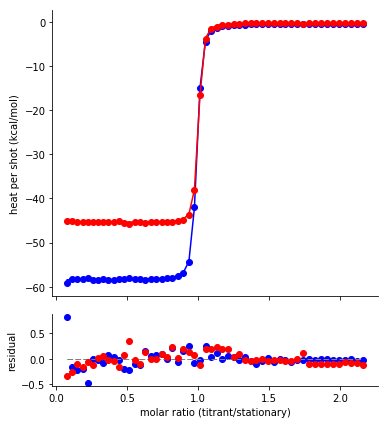

In [2]:
# --------------------------------------------------------------------
# define buffer ionization enthalpies.
# goldberg et al (2002) Journal of Physical and Chemical Reference Data 31 231,  doi: 10.1063/1.1416902
TRIS_IONIZATION_DH = 47.45/4.184*1000
IMID_IONIZATION_DH = 36.64/4.184*1000 

class MyNumProtons(pytc.GlobalConnector):
    param_guesses = {"num_H":0.1,"dH_intrinsic":0.0}
    required_data = ["ionization_enthalpy"]
    
    def dH(self,experiment):

        return self.dH_intrinsic + self.num_H*experiment.ionization_enthalpy


# --------------------------------------------------------------------
# Create a global fitting instance
g = pytc.GlobalFit()
num_protons = MyNumProtons("np")

# ------------------------------------------------------------------------------------
# Tris buffer experiment

tris = pytc.ITCExperiment("ca-edta/tris-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
tris.ionization_enthalpy = TRIS_IONIZATION_DH

g.add_experiment(tris)
g.link_to_global(tris,"dH",num_protons.dH)

# ------------------------------------------------------------------------------------
# Imidazole buffer experiment

imid = pytc.ITCExperiment("ca-edta/imid-01.DH",pytc.indiv_models.SingleSite,shot_start=2)
imid.ionization_enthalpy = IMID_IONIZATION_DH

g.add_experiment(imid)
g.link_to_global(imid,"dH",num_protons.dH)

# --------------------------------------------------------------------
# Do a global fit
g.fit()

# Show the results
fig, ax = g.plot()
print(g.fit_as_csv)